# softmax和分类模型
内容包含：
1. softmax回归的基本概念
2. 如何获取Fashion-MNIST数据集和读取数据
3. softmax回归模型的从零开始实现，实现一个对Fashion-MNIST训练集中的图像数据进行分类的模型
4. 使用pytorch重新实现softmax回归模型


## softmax的基本概念

- 分类问题  
一个简单的图像分类问题，输入图像的高和宽均为2像素，色彩为灰度。  
图像中的4像素分别记为$x_1, x_2, x_3, x_4$。  
假设真实标签为狗、猫或者鸡，这些标签对应的离散值为$y_1, y_2, y_3$。  
我们通常使用离散的数值来表示类别，例如$y_1=1, y_2=2, y_3=3$。

- 权重矢量  
$$
 \begin{aligned} o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1 \end{aligned} 
$$

$$
 \begin{aligned} o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2 \end{aligned} 
$$

$$
 \begin{aligned} o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3 \end{aligned} 
$$

- 神经网络图  
下图用神经网络图描绘了上面的计算。softmax回归同线性回归一样，也是一个单层神经网络。由于每个输出$o_1, o_2, o_3$的计算都要依赖于所有的输入$x_1, x_2, x_3, x_4$，softmax回归的输出层也是一个全连接层。

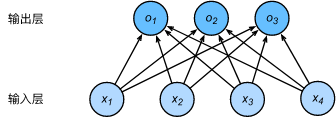

$$
\begin{aligned}softmax回归是一个单层神经网络\end{aligned}
$$

既然分类问题需要得到离散的预测输出，一个简单的办法是将输出值$o_i$当作预测类别是$i$的置信度，并将值最大的输出所对应的类作为预测输出，即输出 $\underset{i}{\arg\max} o_i$。例如，如果$o_1,o_2,o_3$分别为$0.1,10,0.1$，由于$o_2$最大，那么预测类别为2，其代表猫。

- 输出问题  
直接使用输出层的输出有两个问题：
    1. 一方面，由于输出层的输出值的范围不确定，我们难以直观上判断这些值的意义。例如，刚才举的例子中的输出值10表示“很置信”图像类别为猫，因为该输出值是其他两类的输出值的100倍。但如果$o_1=o_3=10^3$，那么输出值10却又表示图像类别为猫的概率很低。
    2. 另一方面，由于真实标签是离散值，这些离散值与不确定范围的输出值之间的误差难以衡量。

softmax运算符（softmax operator）解决了以上两个问题。它通过下式将输出值变换成值为正且和为1的概率分布：

$$
 \hat{y}_1, \hat{y}_2, \hat{y}_3 = \text{softmax}(o_1, o_2, o_3) 
$$

其中

$$
 \hat{y}1 = \frac{ \exp(o_1)}{\sum_{i=1}^3 \exp(o_i)},\quad \hat{y}2 = \frac{ \exp(o_2)}{\sum_{i=1}^3 \exp(o_i)},\quad \hat{y}3 = \frac{ \exp(o_3)}{\sum_{i=1}^3 \exp(o_i)}. 
$$

容易看出$\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$且$0 \leq \hat{y}_1, \hat{y}_2, \hat{y}_3 \leq 1$，因此$\hat{y}_1, \hat{y}_2, \hat{y}_3$是一个合法的概率分布。这时候，如果$\hat{y}_2=0.8$，不管$\hat{y}_1$和$\hat{y}_3$的值是多少，我们都知道图像类别为猫的概率是80%。此外，我们注意到

$$
 \underset{i}{\arg\max} o_i = \underset{i}{\arg\max} \hat{y}_i 
$$

因此softmax运算不改变预测类别输出。

- 计算效率
    - 单样本矢量计算表达式  
    为了提高计算效率，我们可以将单样本分类通过矢量计算来表达。在上面的图像分类问题中，假设softmax回归的权重和偏差参数分别为
   
$$
 \boldsymbol{W} = \begin{bmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \\ w_{31} & w_{32} & w_{33} \\ w_{41} & w_{42} & w_{43} \end{bmatrix},\quad \boldsymbol{b} = \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix}, 
$$

设高和宽分别为2个像素的图像样本$i$的特征为
   
$$
\boldsymbol{x}^{(i)} = \begin{bmatrix}x_1^{(i)} & x_2^{(i)} & x_3^{(i)} & x_4^{(i)}\end{bmatrix},
$$

输出层的输出为

$$
\boldsymbol{o}^{(i)} = \begin{bmatrix}o_1^{(i)} & o_2^{(i)} & o_3^{(i)}\end{bmatrix},
$$

预测为狗、猫或鸡的概率分布为
    
$$
\boldsymbol{\hat{y}}^{(i)} = \begin{bmatrix}\hat{y}_1^{(i)} & \hat{y}_2^{(i)} & \hat{y}_3^{(i)}\end{bmatrix}.
$$

softmax回归对样本$i$分类的矢量计算表达式为
   
$$
 \begin{aligned} \boldsymbol{o}^{(i)} &= \boldsymbol{x}^{(i)} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{y}}^{(i)} &= \text{softmax}(\boldsymbol{o}^{(i)}). \end{aligned} 
$$

- 小批量矢量计算表达式  
    为了进一步提升计算效率，我们通常对小批量数据做矢量计算。广义上讲，给定一个小批量样本，其批量大小为$n$，输入个数（特征数）为$d$，输出个数（类别数）为$q$。设批量特征为$\boldsymbol{X} \in \mathbb{R}^{n \times d}$。假设softmax回归的权重和偏差参数分别为$\boldsymbol{W} \in \mathbb{R}^{d \times q}$和$\boldsymbol{b} \in \mathbb{R}^{1 \times q}$。softmax回归的矢量计算表达式为

$$
 \begin{aligned} \boldsymbol{O} &= \boldsymbol{X} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{Y}} &= \text{softmax}(\boldsymbol{O}), \end{aligned} 
$$

其中的加法运算使用了广播机制，$\boldsymbol{O}, \boldsymbol{\hat{Y}} \in \mathbb{R}^{n \times q}$且这两个矩阵的第$i$行分别为样本$i$的输出$\boldsymbol{o}^{(i)}$和概率分布$\boldsymbol{\hat{y}}^{(i)}$。


## 交叉熵损失函数

对于样本$i$，我们构造向量$\boldsymbol{y}^{(i)}\in \mathbb{R}^{q}$ ，使其第$y^{(i)}$（样本$i$类别的离散数值）个元素为1，其余为0。这样我们的训练目标可以设为使预测概率分布$\boldsymbol{\hat y}^{(i)}$尽可能接近真实的标签概率分布$\boldsymbol{y}^{(i)}$。

- 平方损失估计  

$$
\begin{aligned}Loss = |\boldsymbol{\hat y}^{(i)}-\boldsymbol{y}^{(i)}|^2/2\end{aligned}
$$
  

然而，想要预测分类结果正确，我们其实并不需要预测概率完全等于标签概率。例如，在图像分类的例子里，如果$y^{(i)}=3$，那么我们只需要$\hat{y}^{(i)}_3$比其他两个预测值$\hat{y}^{(i)}_1$和$\hat{y}^{(i)}_2$大就行了。即使$\hat{y}^{(i)}_3$值为0.6，不管其他两个预测值为多少，类别预测均正确。而平方损失则过于严格，例如$\hat y^{(i)}_1=\hat y^{(i)}_2=0.2$比$\hat y^{(i)}_1=0, \hat y^{(i)}_2=0.4$的损失要小很多，虽然两者都有同样正确的分类预测结果。

改善上述问题的一个方法是使用更适合衡量两个概率分布差异的测量函数。其中，交叉熵（cross entropy）是一个常用的衡量方法：


$$
H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)},
$$


其中带下标的$y_j^{(i)}$是向量$\boldsymbol y^{(i)}$中非0即1的元素，需要注意将它与样本$i$类别的离散数值，即不带下标的$y^{(i)}$区分。在上式中，我们知道向量$\boldsymbol y^{(i)}$中只有第$y^{(i)}$个元素$y^{(i)}{y^{(i)}}$为1，其余全为0，于是$H(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}) = -\log \hat y{y^{(i)}}^{(i)}$。也就是说，交叉熵只关心对正确类别的预测概率，因为只要其值足够大，就可以确保分类结果正确。当然，遇到一个样本有多个标签时，例如图像里含有不止一个物体时，我们并不能做这一步简化。但即便对于这种情况，交叉熵同样只关心对图像中出现的物体类别的预测概率。

假设训练数据集的样本数为$n$，交叉熵损失函数定义为 
$$
\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ),
$$


其中$\boldsymbol{\Theta}$代表模型参数。同样地，如果每个样本只有一个标签，那么交叉熵损失可以简写成$\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}$。从另一个角度来看，我们知道最小化$\ell(\boldsymbol{\Theta})$等价于最大化$\exp(-n\ell(\boldsymbol{\Theta}))=\prod_{i=1}^n \hat y_{y^{(i)}}^{(i)}$，即最小化交叉熵损失函数等价于最大化训练数据集所有标签类别的联合预测概率。


## 模型训练和预测
在训练好softmax回归模型后，给定任一样本特征，就可以预测每个输出类别的概率。通常，我们把预测概率最大的类别作为输出类别。如果它与真实类别（标签）一致，说明这次预测是正确的。在3.6节的实验中，我们将使用准确率（accuracy）来评价模型的表现。它等于正确预测数量与总预测数量之比。

# 获取Fashion-MNIST训练集和读取数据
在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST[1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST[2]。

我这里我们会使用torchvision包，它是服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。torchvision主要由以下几部分构成：
1. torchvision.datasets: 一些加载数据的函数及常用的数据集接口；
2. torchvision.models: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
3. torchvision.transforms: 常用的图片变换，例如裁剪、旋转等；
4. torchvision.utils: 其他的一些有用的方法。

In [1]:
# import needed package
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import time

import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)
print(torchvision.__version__)

ModuleNotFoundError: No module named 'torchvision'

## get dataset

In [38]:
mnist_train = torchvision.datasets.FashionMNIST(root='/home/kesci/input/FashionMNIST2065', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='/home/kesci/input/FashionMNIST2065', train=False, download=True, transform=transforms.ToTensor())

class torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=False)
- root（string）– 数据集的根目录，其中存放processed/training.pt和processed/test.pt文件。
- train（bool, 可选）– 如果设置为True，从training.pt创建数据集，否则从test.pt创建。
- download（bool, 可选）– 如果设置为True，从互联网下载数据并放到root文件夹下。如果root目录下已经存在数据，不会再次下载。
- transform（可被调用 , 可选）– 一种函数或变换，输入PIL图片，返回变换之后的数据。如：transforms.RandomCrop。
- target_transform（可被调用 , 可选）– 一种函数或变换，输入目标，进行变换。

In [39]:
# show result 
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [40]:
# 我们可以通过下标来访问任意一个样本
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width


torch.Size([1, 28, 28]) 9


如果不做变换输入的数据是图像，我们可以看一下图片的类型参数：

In [41]:
mnist_PIL = torchvision.datasets.FashionMNIST(root='/home/kesci/input/FashionMNIST2065', train=True, download=True)
PIL_feature, label = mnist_PIL[0]
print(PIL_feature)

<PIL.Image.Image image mode=L size=28x28 at 0x7F57E8736F28>


In [42]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [43]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

In [44]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0]) # 将第i个feature加到X中
    y.append(mnist_train[i][1]) # 将第i个label加到y中
show_fashion_mnist(X, get_fashion_mnist_labels(y))

<Figure size 864x864 with 10 Axes>

In [45]:
# 读取数据
batch_size = 256
num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [46]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.89 sec


# softmax从零开始的实现

In [47]:
import torch
import torchvision
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1a0+d94043a


## 获取训练集数据和测试集数据

In [48]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 模型参数初始化

In [49]:
num_inputs = 784
print(28*28)
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

784


In [50]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 对多维Tensor按维度操作

In [51]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))  # dim为0，按照相同的列求和，并在结果中保留列特征
print(X.sum(dim=1, keepdim=True))  # dim为1，按照相同的行求和，并在结果中保留行特征
print(X.sum(dim=0, keepdim=False)) # dim为0，按照相同的列求和，不在结果中保留列特征
print(X.sum(dim=1, keepdim=False)) # dim为1，按照相同的行求和，不在结果中保留行特征

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])
tensor([5, 7, 9])
tensor([ 6, 15])


## 定义softmax操作

$$
 \hat{y}_j = \frac{ \exp(o_j)}{\sum_{i=1}^3 \exp(o_i)} 
$$



In [52]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    # print("X size is ", X_exp.size())
    # print("partition size is ", partition, partition.size())
    return X_exp / partition  # 这里应用了广播机制

In [53]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, '\n', X_prob.sum(dim=1))

tensor([[0.1927, 0.2009, 0.1823, 0.1887, 0.2355],
        [0.1274, 0.1843, 0.2536, 0.2251, 0.2096]]) 
 tensor([1., 1.])


## softmax回归模型
 
$$
 \begin{aligned} \boldsymbol{o}^{(i)} &= \boldsymbol{x}^{(i)} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{y}}^{(i)} &= \text{softmax}(\boldsymbol{o}^{(i)}). \end{aligned} 
$$



In [54]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 定义损失函数

$$
H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)},
$$
  

$$
\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ),
$$
  

$$
\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}
$$
  



In [55]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [56]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 定义准确率
    我们模型训练完了进行模型预测的时候，会用到我们这里定义的准确率。

In [57]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [58]:
print(accuracy(y_hat, y))

0.5


In [59]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [60]:
print(evaluate_accuracy(test_iter, net))

0.1457


## 训练模型

In [61]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step() 
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7870, train acc 0.751, test acc 0.794
epoch 2, loss 0.5702, train acc 0.813, test acc 0.809
epoch 3, loss 0.5254, train acc 0.826, test acc 0.814
epoch 4, loss 0.5009, train acc 0.832, test acc 0.822
epoch 5, loss 0.4853, train acc 0.837, test acc 0.828


## 模型预测
现在我们的模型训练完了，可以进行一下预测，我们的这个模型训练的到底准确不准确。
现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

In [62]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

<Figure size 864x864 with 9 Axes>

# softmax的简洁实现

In [63]:
# 加载各种包或者模块
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l

print(torch.__version__)

1.3.0


## 初始化参数和获取数据

In [64]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 定义网络模型

In [65]:
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x 的形状: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y
    
# net = LinearNet(num_inputs, num_outputs)

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x 的形状: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

from collections import OrderedDict
net = nn.Sequential(
        # FlattenLayer(),
        # LinearNet(num_inputs, num_outputs) 
        OrderedDict([
           ('flatten', FlattenLayer()),
           ('linear', nn.Linear(num_inputs, num_outputs))]) # 或者写成我们自己定义的 LinearNet(num_inputs, num_outputs) 也可以
        )

## 初始化模型参数

In [66]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 定义损失函数

In [67]:
loss = nn.CrossEntropyLoss() # 下面是他的函数原型
# class torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

## 定义优化函数

In [68]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # 下面是函数原型
# class torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)

## 训练

In [69]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.749, test acc 0.794
epoch 2, loss 0.0022, train acc 0.814, test acc 0.800
epoch 3, loss 0.0021, train acc 0.826, test acc 0.811
epoch 4, loss 0.0020, train acc 0.833, test acc 0.826
epoch 5, loss 0.0019, train acc 0.837, test acc 0.825
